In [5]:
# country.code <- 'usa'  # use yours
# url.pattern <- 'https://'  # use http if you want
# repo.data.frame <- subset(getCRANmirrors(), CountryCode == country.code & grepl(url.pattern, URL))
# options(repos = repo.data.frame$URL)
#install.packages("arules", repos = "http://cran.rstudio.com/")
# install.packages("arulesViz", repos = "http://cran.rstudio.com/")
# install.packages("visNetwork", repos = "http://cran.rstudio.com/")
#install.packages("caTools", repos = "http://cran.rstudio.com/")
library(BayesianFirstAid)
library(arules)
library(arulesViz)
library(ggplot2)
library(plotly)
library(ggvis)
library(scatterD3)
library(visNetwork)
library(igraph)
library(data.table)
library(discretization)
library(infotheo)
options(jupyter.plot_mimetypes = 'image/png')

In [3]:
data <-read.table("model_accidents.csv",header=TRUE,sep=",",na.strings="NA",stringsAsFactors=TRUE,blank.lines.skip=TRUE,skipNul=TRUE,fill=TRUE)

In [4]:
# ## Let's see if any of the Pedestrian/Pedalcyclist Accident characteristics can be used as parameters in predicting: 
#    ## 1.) a serious accident ("Incapacitating" or Fatal Injury) -> injury = "severe"
#     ## 2.) a pedestrian vs a pedalcyclist injury   
data$injury <- data$crash_severity %in% c("A Injury Crash","Fatal Crash")
data$pedtype <- data$accident_type == 1

data$injury <- factor(data$injury,labels=c("non_severe","severe"))
data$pedtype <- factor(data$pedtype,labels=c("pedalcyclist","pedestrian"))
data$hr <- as.factor(data$hr)
data$trafficway <- as.factor(data$trafficway)
data$road_surface <- as.factor(data$road_surface)
data$lighting <- as.factor(data$lighting)
data$weather <- as.factor(data$weather)
data$roadway <- as.factor(data$roadway)
# discrete <- discretize(data$ct_1m)
# data$ct_1m_bin <- as.factor(discretize$X)
data$ct_1m_bin <- as.factor(as.numeric(cut_number(data$ct_1m,10)))
str(data)

'data.frame':	12973 obs. of  27 variables:
 $ X                : int  0 40 62 91 836 861 894 936 970 1026 ...
 $ id               : num  7753890 7736171 7736175 7763023 7736186 ...
 $ daytetime        : Factor w/ 9107 levels "2012-01-01 00:00:00",..: 6348 6216 6223 6395 6229 6386 6344 6345 6289 6385 ...
 $ datetime_accident: Factor w/ 12675 levels "2012-01-01 00:39:00",..: 8792 8617 8630 8851 8639 8837 8787 8789 8714 8836 ...
 $ accident_type    : num  1 1 1 1 1 1 1 1 2 1 ...
 $ road_surface     : Factor w/ 7 levels "1","2","3","4",..: 1 3 2 1 2 2 3 3 1 3 ...
 $ lighting         : Factor w/ 6 levels "1","2","3","4",..: 1 5 5 1 1 5 5 5 1 3 ...
 $ weather          : Factor w/ 9 levels "1","2","3","4",..: 1 3 2 9 2 1 3 1 1 1 ...
 $ intersection     : Factor w/ 2 levels "N","Y": 1 1 1 2 2 1 1 2 1 2 ...
 $ hit_run          : Factor w/ 2 levels "N","Y": 2 2 2 2 1 2 2 2 2 1 ...
 $ trafficway       : Factor w/ 13 levels "1","2","3","4",..: 3 2 1 10 2 1 9 2 2 1 ...
 $ roadway          : Factor 

In [7]:
## Use Association Rules with Apriori methods to find frequencies that may indicate separately, the Severe/Non_Severe Injuries, or Pedestrian vs Pedalcyclist.
 ## 1st, do it for Injury type
keeps <- c("road_surface","lighting","weather","intersection","hit_run","trafficway","roadway","day_of_wk","hr","ct_1m_bin","pedtype","injury")
aprioriset = data[keeps]

In [4]:
rules<-apriori(aprioriset,parameter=list(supp=.001,conf=.9))
# rules with rhs containing "injury" only
rules <- apriori(aprioriset,parameter = list(minlen=2, supp=0.003, conf=0.9),appearance = list(rhs=c("injury=severe", "injury=non_severe"),default="lhs"),control = list(verbose=F))
rules.sorted <- sort(rules, by="lift")
inspect(rules.sorted)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport support minlen maxlen target
        0.9    0.1    1 none FALSE            TRUE   0.001      1     10  rules
   ext
 FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 12 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[90 item(s), 12973 transaction(s)] done [0.01s].
sorting and recoding items ... [88 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 done [0.84s].
writing ... [441911 rule(s)] done [0.18s].
creating S4 object  ... done [0.48s].
      lhs                       rhs                     support confidence     lift
1     {road_surface=9,                                                             
       ct_1m_bin=3}          => {injury=non_severe} 0.003699992  1.0000000 1.149172
2     {hit_run=N,               

From this analysis, it seems that we can much easier draw concrete rules for 'Non_severe' accidents. Driveway or Alley accidents are strong rules; would this be accidents where a driver is pulling out of the alley/parking garage in a location like the loop?

   lhs                               rhs                 support     confidence
1  {trafficway=13}                => {injury=non_severe} 0.003854159 0.9090909 
2  {trafficway=6}                 => {injury=non_severe} 0.009866646 0.9142857 
3  {hr=10}                        => {injury=non_severe} 0.034687428 0.9000000 
4  {road_surface=9}               => {injury=non_severe} 0.036537424 0.9257812 
5  {trafficway=9}                 => {injury=non_severe} 0.040237416 0.9321429 
6  {ct_1m_bin=7}                  => {injury=non_severe} 0.088106066 0.9078634 
7  {pedtype=pedalcyclist}         => {injury=non_severe} 0.344793032 0.9069343 
8  {intersection=N,trafficway=13} => {injury=non_severe} 0.003622909 0.9215686 
9  {intersection=N,trafficway=7}  => {injury=non_severe} 0.007245818 0.9038462 
10 {hit_run=N,trafficway=7}       => {injury=non_severe} 0.005472905 0.9102564 
   lift    
1  1.044702
2  1.050671
3  1.034255
4  1.063882
5  1.071192
6  1.043291
7  1.042223
8  1.059041
9  1.038674


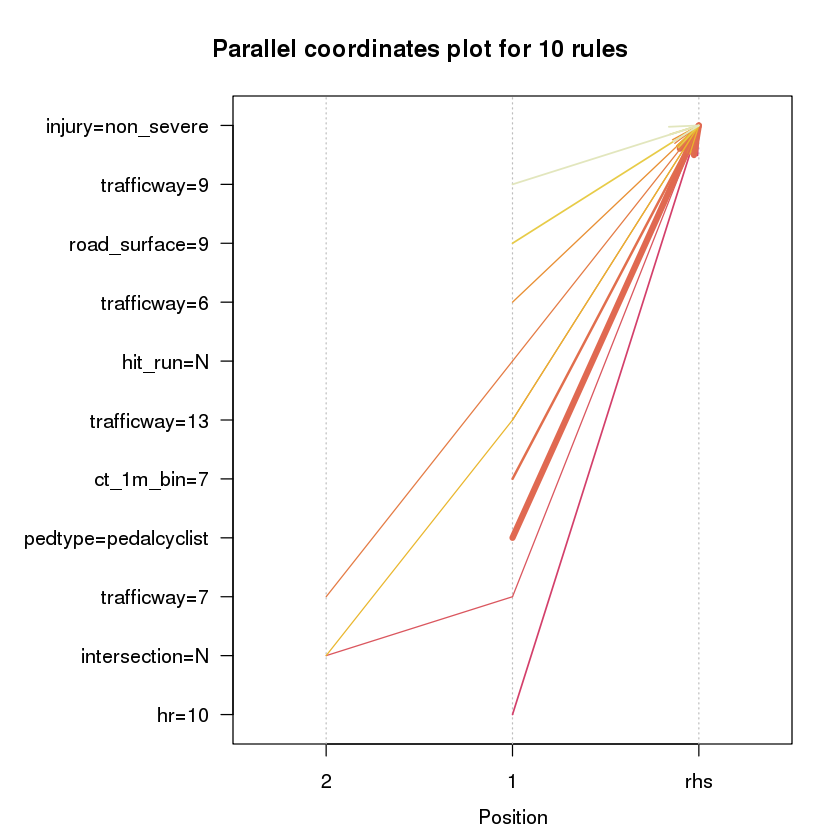

In [5]:
# find redundant rules and then plot the top 15 Rules at predicting Injury ...(which all appear to predict 'Non_Severe' outcome only; seems 'severe' outcome has less frequent itemsets)
subset.matrix <- is.subset(rules.sorted, rules.sorted)
subset.matrix[lower.tri(subset.matrix, diag=T)] <- NA
redundant <- colSums(subset.matrix, na.rm=T) >= 1

rules.pruned <- rules.sorted[!redundant]
top10 <- rules[1:10,]
inspect(top10)
plot(top10, method="graph", control=list(type="items"))
plot(top10, method="paracoord", control=list(reorder=TRUE))

In [8]:
# Now look to use Supervised method for pedestrian/pedalcyclist
rules <- apriori(aprioriset,parameter = list(minlen=2, supp=0.003, conf=0.9),appearance = list(rhs=c("pedtype=pedestrian", "pedtype=pedalcyclist"),default="lhs"),control = list(verbose=F))
rules.sorted <- sort(rules, by="lift")
inspect(rules.sorted)

    lhs                      rhs                      support confidence     lift
1   {weather=3,                                                                  
     trafficway=2,                                                               
     roadway=70}          => {pedtype=pedestrian} 0.003006244  1.0000000 1.613357
2   {road_surface=3,                                                             
     trafficway=2,                                                               
     roadway=70}          => {pedtype=pedestrian} 0.003468743  1.0000000 1.613357
3   {road_surface=3,                                                             
     trafficway=2,                                                               
     roadway=70,                                                                 
     injury=non_severe}   => {pedtype=pedestrian} 0.003083327  1.0000000 1.613357
4   {road_surface=3,                                                             
     lighting=1,

It looks like there is a good deal of snowy wintery condition Pedestrian accidents that really help distinguish an accident as Pedestrian. Perhaps there's more than just time of year here (Jan, etc.); perhaps they are all commuters in heavy density work areas?

In [9]:
# find redundant rules
subset.matrix <- is.subset(rules.sorted, rules.sorted)
subset.matrix[lower.tri(subset.matrix, diag=T)] <- NA
redundant <- colSums(subset.matrix, na.rm=T) >= 1

rules.pruned <- rules.sorted[!redundant]
top10 <- rules[1:15,]
inspect(top10)
plot(top10, method="graph", control=list(type="items"))
plot(top10, method="paracoord", control=list(reorder=TRUE))

   lhs                      rhs                      support confidence     lift
1  {hit_run=Y,                                                                  
    hr=3}                => {pedtype=pedestrian} 0.004470824  0.9062500 1.462104
2  {weather=3,                                                                  
    ct_1m_bin=3}         => {pedtype=pedestrian} 0.003160410  0.9318182 1.503355
3  {weather=3,                                                                  
    day_of_wk=Tuesday}   => {pedtype=pedestrian} 0.004085408  0.9137931 1.474274
4  {weather=3,                                                                  
    roadway=70}          => {pedtype=pedestrian} 0.007245818  0.9591837 1.547505
5  {weather=3,                                                                  
    hit_run=Y}           => {pedtype=pedestrian} 0.007322901  0.9047619 1.459704
6  {weather=3,                                                                  
    intersection=Y}      => 

In [10]:
## Create a set of Training and Testing Data Sets for Machine learning algorithms in H2O, to be used next to attempt to predict Injury Type.
require(caTools)
set.seed(101) 
sample = sample.split(aprioriset$injury, SplitRatio = .70)
train = subset(aprioriset, sample == TRUE)
test = subset(aprioriset, sample == FALSE)

Loading required package: caTools


In [11]:
library(h2o)
localH2O <- h2o.init(ip = 'localhost', port = 54321, nthreads= 10, max_mem_size = '150g')

Loading required package: statmod

----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: ‘h2o’

The following objects are masked from ‘package:data.table’:

    hour, month, week, year

The following object is masked from ‘package:arules’:

    %in%

The following objects are masked from ‘package:stats’:

    sd, var

The following objects are masked from ‘package:base’:

    %*%, %in%, apply, as.factor, as.numeric, colnames, colnames<-,
    ifelse, is.factor, is.numeric, log, trunc



Successfully connected to http://localhost:54321/ 

R is connected to the H2O cluster: 
    H2O cluster uptime:         20 hours 42 seconds 
    H2O cluster version:        3.6.0.3 
    H2O cluster name:           H2O_started_from_R_ecoker_xyo159 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   133.33 GB 
    H2O cluster total cores:    16 
    H2O cluster allowed cores:  10 
    H2O cluster healthy:        TRUE 



In [12]:
# Predict Severe Injury using characterists and other frequentists methods in H2O.ai algorithms (generalized linear model, gradient boosted machines, random forest)
 ## The Random Forest model had the lowest Error Rate, especially for the minor class ("severe" injury), so I'd like to focus on the RF variable importances for insight into
    ## determining the Injury of the Accident as Severe/Non-Severe. It appears that Hour of the day, Nbr of Liquor establishments nearby, day of the week and whether it was a busy street have
    ## a lot to do with the outcome of injury. I think there's more to look at here.

### Variable Importances: 
###        variable relative_importance scaled_importance percentage
### 1            hr         7055.526367          1.000000   0.272130
### 2     ct_1m_bin         3957.596680          0.560922   0.152643
### 3     day_of_wk         3494.784180          0.495326   0.134793
### 4    trafficway         2869.089844          0.406644   0.110660


inj_v.hex <- as.h2o(test)
inj_t.hex <- as.h2o(train)
summary(inj_v.hex)

inj_glm=h2o.glm(y=12,x=c(1,2,3,4,5,6,7,8,9,10,11),training_frame=inj_t.hex,validation_frame=inj_v.hex,standardize=T,alpha=1,family='binomial')
inj_glm2=h2o.glm(y=12,x=c(1,2,3,4,5,6,7,8,9,10,11),training_frame=inj_t.hex,validation_frame=inj_v.hex,standardize=T,alpha=0,family='binomial')
inj_gbm=h2o.gbm(y=12,x=c(1,2,3,4,5,6,7,8,9,10,11),training_frame=inj_t.hex,validation_frame=inj_v.hex)
inj_rf=h2o.randomForest(y=12,x=c(1,2,3,4,5,6,7,8,9,10,11),training_frame=inj_t.hex,validation_frame=inj_v.hex,nfolds=10)

summary(inj_glm)
summary(inj_glm2)
summary(inj_gbm)
summary(inj_rf)

  |======================================================================| 100%
  |======================================================================| 100%


 road_surface lighting weather intersection hit_run trafficway roadway 
 1:3040       1:2577   1:3163  Y:2213       N:2744  1 :1422    80:1254 
 2: 557       5: 886   2: 407  N:1679       Y:1148  2 :1317    70:1167 
 9: 150       4: 190   3: 105                       10: 297    30: 738 
 3: 122       3: 114   9:  98                       3 : 203    90: 655 
 6:  11       9:  69   8:  45                       9 : 174    0 :  22 
 4:   7       2:  56   4:  44                       5 : 148    10:  14 
                                                               NA:  42 
 day_of_wk      hr      ct_1m_bin pedtype            injury          
 Friday   :665  18:349  8 :424    pedestrian  :2404  non_severe:3387 
 Thursday :601  17:334  7 :400    pedalcyclist:1488  severe    : 505 
 Tuesday  :587  16:307  1 :380                                       
 Wednesday:571  15:297  9 :380                                       
 Monday   :561  8 :222  10:377                                       
 Sat

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1453059749563_117 
GLM Model: summary
    family  link             regularization number_of_predictors_total
1 binomial logit Lasso (lambda = 1.459E-5 )                         89
  number_of_active_predictors number_of_iterations              training_frame
1                          83                    6 file4bc35ea4a4a_csv_3.hex_4

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.1093531
R^2:  0.02950809
LogLoss:  0.3723165
AUC:  0.6290923
Gini:  0.2581847
Null Deviance:  6870.708
Residual Deviance:  6639.148
AIC:  6807.148

Confusion Matrix for F1-optimal threshold:
           non_severe 

All the models perform closely the same, depends mostly on my acceptance of incorrect class predictions for the minor class, "severe". But I see a common theme among all models, even though most of the predictors/parameters differ. The type of road and time of day are important. And my created variable 'ct_1m_bin', which tells how many liquor establishments are within 1 mile of the accident, has some value. This is more reason to work on getting the traffic data from the City of Chicago Data Portal, with correct 'hour' in the timestamp. I think that Traffic/Congestion estimates near the accident site will be strong indicators. 
Other things to consider is could I create 'typical' or normal conditions and then sample that against all accident data? That would allow me to understand which of these parameters I have for the accident are most important in predicting any accident. This would just require creating a mock dataset with true typical conditions, to measure against this biased accident conditions.

In [ ]:
## TO DO; try some Bayesian prediction methods